# 1.0 Importing dependencies

In [ ]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image
from IPython.display import display
from time import gmtime, strftime
from sagemaker.predictor import csv_serializer

# Define IAM role
role = get_execution_role()
prefix = 'diabetes-detection'
my_region = boto3.session.Session().region_name # set the region of the instance

# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", my_region, "latest")

print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + xgboost_container + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the ap-south-1 region. You will use the 991648021394.dkr.ecr.ap-south-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


# 2.0 S3 Bucket creation to store data

In [ ]:
bucket_name = 'diabetes-detection-bucket' 
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
      s3.create_bucket(Bucket=bucket_name)
    else: 
      s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 error:  An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


# 3.0 Importing Data

In [ ]:
try:
  urllib.request.urlretrieve("https://raw.githubusercontent.com/sanjayd89/Diabetes_detection_on_AWS_Sagemaker/main/diabetes_data.csv", "diabetes_data.csv")
  print('Success: downloaded diabetes_data.csv.')
except Exception as e:
  print('Data load error: ',e)

try:
  model_data = pd.read_csv('diabetes_data.csv')#,index_col=0)
  print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)
model_data.head()

Success: downloaded diabetes_data.csv.
Success: Data loaded into dataframe.


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


# 4.0 Pre-processing and EDA

In [ ]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [ ]:
model_data.isna().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

## Dependent Class distribution

<AxesSubplot:ylabel='class'>

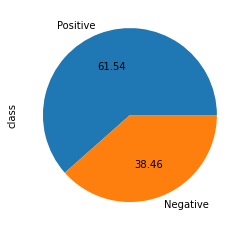

In [ ]:
model_data['class'].value_counts().plot(kind = 'pie', autopct='%.2f')

## Class Distribution across Independent Variables

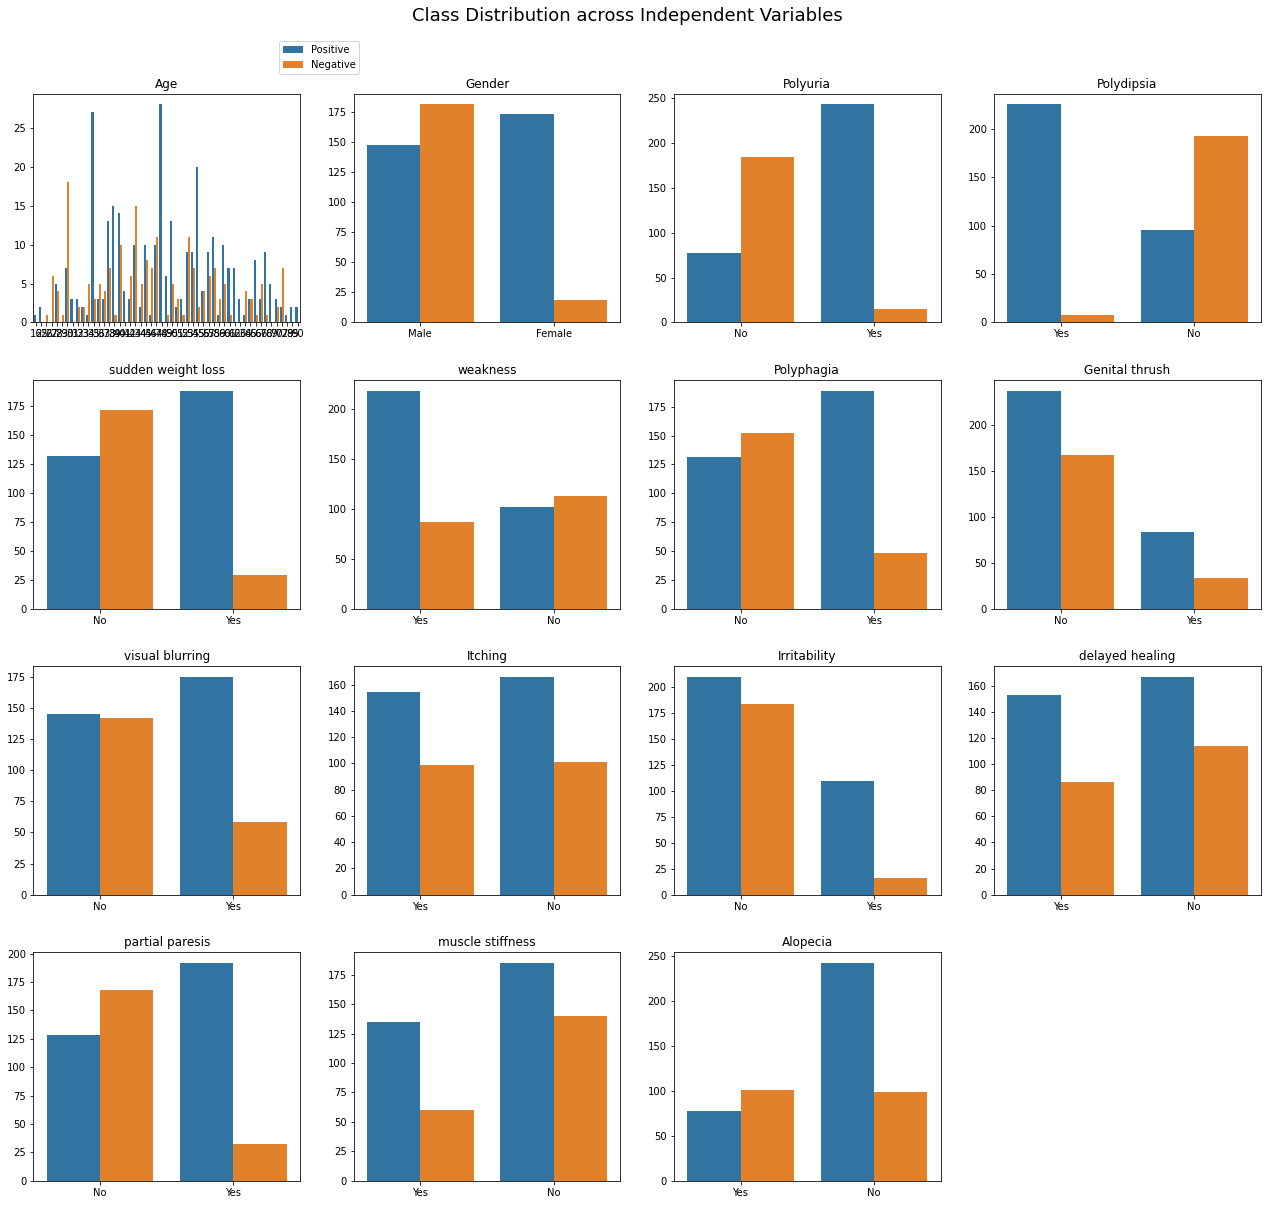

In [ ]:
plt.figure(figsize=(22, 20))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Class Distribution across Independent Variables", fontsize=18, y=0.94)
col_list = list(model_data)[:-2]

# loop through the length of tickers and keep track of index
for n, col in enumerate(col_list):
    # add a new subplot iteratively
    ax = plt.subplot(4, 4, n + 1)

    # filter df and plot ticker on the new subplot axis
    ax = sns.countplot(data=model_data, x=col, hue='class');

    # chart formatting
    ax.set_title(col)
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(-1.5,5))
plt.show()

## One Hot Encoding the Independent variables

In [ ]:
ohe_col_list = model_data.columns.to_list()[1:]

In [ ]:
model_data_ohe = pd.get_dummies(model_data, columns = ohe_col_list, drop_first=True)
model_data_ohe.head()

,Age,Gender_Male,Polyuria_Yes,Polydipsia_Yes,sudden weight loss_Yes,weakness_Yes,Polyphagia_Yes,Genital thrush_Yes,visual blurring_Yes,Itching_Yes,Irritability_Yes,delayed healing_Yes,partial paresis_Yes,muscle stiffness_Yes,Alopecia_Yes,Obesity_Yes,class_Positive
0,40,1,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,1,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


# 5.0 Modeling

## Train Test Split

In [ ]:
train_data, test_data = np.split(model_data_ohe.sample(frac=1, random_state=1729), [int(0.7 * len(model_data_ohe))])
print(train_data.shape, test_data.shape)

(364, 17) (156, 17)


In [ ]:
#export to csv keeping target class as first column
pd.concat([train_data['class_Positive'], train_data.drop(['class_Positive'], axis=1)], 
          axis=1).to_csv('train.csv', index=False, header=False)

#upload train file to s3 bucket
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

## Create instance of XGB within Sagemaker along with its hyperparameters

In [ ]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, instance_count=1, instance_type='ml.m4.xlarge',output_path='s3://{}/{}/output'.format(bucket_name, prefix),sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,silent=0,objective='binary:logistic',num_round=100)

In [ ]:
xgb.fit({'train': s3_input_train})

2022-11-21 10:23:03 Starting - Starting the training job...
2022-11-21 10:23:28 Starting - Preparing the instances for trainingProfilerReport-1669026183: InProgress
............
2022-11-21 10:25:27 Downloading - Downloading input data...
2022-11-21 10:25:57 Training - Training image download completed. Training in progress..Arguments: train
[2022-11-21:10:26:05:INFO] Running standalone xgboost training.
[2022-11-21:10:26:05:INFO] Path /opt/ml/input/data/validation does not exist!
[2022-11-21:10:26:05:INFO] File size need to be processed in the node: 0.01mb. Available memory size in the node: 8621.41mb
[2022-11-21:10:26:05:INFO] Determined delimiter of CSV input is ','
[10:26:05] S3DistributionType set as FullyReplicated
[10:26:05] 364x16 matrix with 5824 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[10:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=3
[0]#011train-error:0.112637
[10:26:05] sr

# 6.0 Deployment

In [ ]:
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

------!

In [ ]:
from sagemaker.serializers import CSVSerializer

test_data_array = test_data.drop(['class_Positive'], axis=1).values #load the data into an array
xgb_predictor.serializer = CSVSerializer() # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(156,)


# 7.0 Evaluation

In [ ]:
cm = pd.crosstab(index=test_data['class_Positive'], columns=np.round(predictions_array), 
                 rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; 
tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; 

p = (tp+tn)/(tp+tn+fp+fn)*100

print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Accuracy: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "Negative", "Positive"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("Negative", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Positive", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Accuracy: 94.2%

Predicted      Negative       Positive
Observed
Negative       91% (50)     4% (4)
Positive        9% (5)     96% (97) 



## Prediction for single patient

In [ ]:
single_patient = [42, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]

In [ ]:
sg_predictions = xgb_predictor.predict(single_patient)
sg_predictions_array = np.round(np.fromstring(sg_predictions, sep=','))
if sg_predictions_array == 1:
    print('Patient has diabetes')
else:
    print('Patient does not have diabetes')

Patient has diabetes


# 8.0 Clean up

In [ ]:
xgb_predictor.delete_endpoint(delete_endpoint_config=True)

In [ ]:
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()